In [2]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime 

from nilearn import plotting, image, masking
from nilearn.plotting import plot_roi

import pandas as pd
import subprocess

import json  
from pandas import json_normalize, read_json
import plotly
import plotly.express as px


%matplotlib widget





In [3]:
def convert2NIFTI(base_folder=Path.home()/'Sync/MRdata/Avanto_MR2',**kwargs): 
    now=datetime.now()
    base_folder=Path(base_folder)
    
    output_folder_name = kwargs.get('output_folder_name', 'NIFTI')
    dcm2niix_path = kwargs.get('dcm2niix_path', 'dcm2niix')
    dcm2niix_flag = kwargs.get('dcm2nixx_flag', False) # Set dcm2nixx_flag=True to skip redoing the NIFTI conversion. (Creates an empty file 'dcm2niix_done' in every folder were dcm2niix was used). 

    print('Checking if DICOM to NIFTI conversion is needed:\n')
    ## get the testfolders in the base_folder (single child)
    testfolders=[folder for folder in sorted(base_folder.glob('*')) if folder.is_dir()]
    needs_dcm2niix=[]
    for i,testfolder in enumerate(testfolders):
        nf=[str(k) for k in testfolder.glob(output_folder_name)]
        qf=[str(k) for k in testfolder.glob("dcm2niix_done")]
        # print(f'nf={nf}')
        # print(f'qf={qf}')

        if (nf or qf):
            print(f'Skipping {testfolder.name}  (already converted)')
     
        if not (nf or qf):
            needs_dcm2niix.append(testfolder)
            # print(f'testfolders[{i}]={testfolder} is empty')
            
            
    output_folder=[]
    output_folder2=[]
    
    for i,folder in enumerate(needs_dcm2niix):
        
        
        # input_folder=needs_dcm2niix[0]
        input_folder=folder
        output_folder.append(input_folder/output_folder_name)
        output_folder2.append(Path('/Users/papo/Desktop/test/'+input_folder.name))
#         output_folder2.append(Path('/Users/papo/Desktop/test/'+input_folder.name+now.strftime("_%d%b%Y")))
        
        try:
            output_folder2[i].mkdir(parents=True, exist_ok=False)
            if i == 0:
                print(f'\nRunning dcm2niix on the following folder(s):')
            print(folder) 
        except:
            print(f'Skipping {folder.name}  (already done)')
            continue
            
    
        dcm2niix_command=' '.join([dcm2niix_path,'-ba n','-o',str(output_folder2[i].resolve()), str(input_folder.resolve())])
        subprocess.run(dcm2niix_command, capture_output=True, shell=True) 
        
        if dcm2niix_flag:
            flag=folder/'dcm2niix_done'
            subprocess.run(['touch', flag.resolve()])


    print(f'\nNIFTI conversion step checked and completed.\n')

    return(output_folder2)


In [4]:
folders=convert2NIFTI('/Users/papo/Sync/Projects/RT_Ingenia_QA/RT_Ingenia_Coil_data')



Checking if DICOM to NIFTI conversion is needed:

Skipping Anterior11  (already done)
Skipping Anterior12  (already done)
Skipping Flex_L  (already done)
Skipping Flex_M  (already done)
Skipping Flex_S  (already done)
Skipping Head_Neck_Coil  (already done)
Skipping Head_coil  (already done)
Skipping photos  (already done)

NIFTI conversion step checked and completed.



In [5]:
def parse_files(folder):
    file_dic=[]
    folder=Path(folder)


    ''' Make sure the NIFTI and JSON files correspond to each other 
    '''
    for (nifti, json) in zip(sorted(folder.rglob('*DQA*.nii')),sorted(folder.rglob('*DQA*.json'))):
        if nifti.stem == json.stem:
            file_dic.append({ 'nifti':nifti, 'json':json })        
        else:
            raise Exception(f'NIFTI and JSON files do NOT match:\nNIFTI: {nifti.name}\nJSON:  {json.name}')


    ''' Make sure the NIFTIs correspond to the 1st and 2nd scans of the sequence (not from other sequences) 
    '''
    itr=iter(file_dic)
    file_dic2=[]
    for i in range(round(len(file_dic)/2)):
        f1=next(itr)
        f2=next(itr)

        f2stem=f2['nifti'].stem
        suffix_index=f2stem.rfind('_')
        f2_nosuffix=f2stem[0:suffix_index]

        if f1['nifti'] != f2['nifti'] and f1['nifti'].stem == f2_nosuffix:
            file_dic2.append({ 'nifti1': f1['nifti'],  'nifti2': f2['nifti'],  'json1': f1['json'],  'json2': f2['json'] })

        else:
            nif1=f1['nifti']
            nif2=f2['nifti']
            raise Exception(f'1st and 2nd NIFTI files do NOT match:\n1st NIFTI: {nif1.name}\n2nd NIFTI: {nif2.name}')

    return(file_dic2)


In [6]:


for test,files in enumerate(parse_files('/Users/papo/Desktop/test')):
    n1=files['nifti1']
    n2=files['nifti2']
    j1=files['json1']
    j2=files['json2']
    print(f'SNR test number {test+1}:')
    print(f'1st nifti: {n1}\n2nd nifti: {n2}')
#     print(f'1st json: {j1}\n2nd json: {j2}')
    print(' ')



# df2=df_j1.loc[:, ['ReceiveCoilName', 'ReceiveCoilActiveElements']]



SNR test number 1:
1st nifti: /Users/papo/Desktop/test/Anterior11/Anterior11_Ant_Post_DQA_2dynamics_20200715162653_201.nii
2nd nifti: /Users/papo/Desktop/test/Anterior11/Anterior11_Ant_Post_DQA_2dynamics_20200715162653_201_t88000.nii
 
SNR test number 2:
1st nifti: /Users/papo/Desktop/test/Anterior12/Anterior12_Ant_Post_DQA_2dynamics_20200715160823_401.nii
2nd nifti: /Users/papo/Desktop/test/Anterior12/Anterior12_Ant_Post_DQA_2dynamics_20200715160823_401_t88000.nii
 
SNR test number 3:
1st nifti: /Users/papo/Desktop/test/Flex_L/Flex_L_Flex_coil_DQA_2dynamics_20200715144644_201.nii
2nd nifti: /Users/papo/Desktop/test/Flex_L/Flex_L_Flex_coil_DQA_2dynamics_20200715144644_201_t108000.nii
 
SNR test number 4:
1st nifti: /Users/papo/Desktop/test/Flex_M/Flex_M_Flex_coil_DQA_2dynamics_20200715145941_301.nii
2nd nifti: /Users/papo/Desktop/test/Flex_M/Flex_M_Flex_coil_DQA_2dynamics_20200715145941_301_t108000.nii
 
SNR test number 5:
1st nifti: /Users/papo/Desktop/test/Flex_S/Flex_S_Flex_coil_DQA

In [7]:
plt.close('all')
class SNR_test:
    """SNR_test class computes SNR test from two nilean images (substraction method). 
    """
    
    def __init__(self, files): 
        """[summary]
        
        Keyword Arguments:
            i1 {[nilean image]} -- [1st volume] (default: {i1})
            i2 {[nilean image]} -- [2nd volume] (default: {i2})
        """
        self.script_version=0.4
        self.im1_path=str(files['nifti1'])
        im2_path=str(files['nifti2'])
        j1=str(files['json1'])
        name=str(files['nifti1'].stem)
        self.name=name[0:name.find('_DQA')]
        self.i1=image.load_img(self.im1_path)
        self.i2=image.load_img(im2_path)
        self.j1=self.load_json(j1)
        self.calc_global_SNR()
        self.calc_nSNR()
        self.create_results_df()
#         self.plot()
    
    
    def load_json(self,jfile):
        with open(jfile) as f: 
            j = json.load(f) 
            j=json_normalize(j)
        return(j.transpose().to_dict()[0])


    
    def calc_SNR(self,signal,noise):
        signal[signal==0]=np.nan
#         noise[signal==0]=np.nan   
        SNR=np.nanmean(signal)/np.nanstd(noise)/np.sqrt(2)
        SNR_std=np.nanstd(signal)/np.nanstd(noise)/np.sqrt(2)
        return SNR,SNR_std

    def calc_global_SNR(self):
        self.imean=image.mean_img([self.i1, self.i2])
        self.isub=image.math_img("(i2 - i1)", i1=self.i1, i2=self.i2)
        self.mask=masking.compute_epi_mask(self.imean)      
        imean=masking.apply_mask(self.imean,self.mask)
        isub=masking.apply_mask(self.isub,self.mask)
        self.SNR_global,self.SNR_global_std=self.calc_SNR(imean,isub)

        
    def calc_nSNR(self):
        # Slice_fact=1000*nfe*npe/(fovFE*fovPE*slide_thk)/sqrt(npe*TR);
        # nbw=sqrt(bw/30)
        # nSNR=SNR*nbw*Slice_fact
        info=self.j1
        npe=info['PhaseEncodingSteps']
        nfe=int(np.round(100*npe/info['PercentSampling']))
        self.sl_thk=info['SliceThickness']
        self.TR=info['RepetitionTime']
        pdims=self.i1.header['pixdim']
        
        self.recon_matrix=info['ReconMatrixPE']
        pdim1=self.recon_matrix/nfe*pdims[1] #Acquired pixel width (pre-reconstruction)
        pdim2=self.recon_matrix/npe*pdims[2]
        pdim3=self.sl_thk
        self.acquisiton_matrix=(nfe,npe) 
        self.acquisiton_pixdim=(pdim1,pdim2,pdim3)
        Slice_fact=1000/(pdim1*pdim2*pdim3)/np.sqrt(npe*self.TR)
        self.pixel_bandwidth=info['PixelBandwidth']
        self.BW_KHz=self.pixel_bandwidth*nfe/1000  #Or PixelBandwidth*info['ReconMatrixPE'] ?
        nBW=np.sqrt(self.BW_KHz/30)
        self.nSNR=self.SNR_global*nBW*Slice_fact
        self.nSNR_std=self.SNR_global_std*nBW*Slice_fact

        
    def create_results_df(self):
        results={'Name': self.name, 'NSNR': self.nSNR,'NSNR_std': self.nSNR_std, 
                  'SNR': self.SNR_global,'SNR_std': self.SNR_global_std, 
                  'File': self.im1_path, 'AcquisitonMatrix': self.acquisiton_matrix, 
                  'AcquisitonPixdim': self.acquisiton_pixdim, 'BW_KHz': self.BW_KHz,
                  'ScriptVersion':self.script_version} 
        results_snr = results.items()
        results_snr_df=pd.DataFrame(data=results_snr).transpose()
        info = self.j1.items()
        info_df=pd.DataFrame(info).transpose()
        results_df=pd.concat([results_snr_df,info_df],axis=1)
        new_header = results_df.iloc[0] 
        results_df = results_df[1:] 
        results_df.columns = new_header
        self.results_df=results_df
        
        
    def calc_SNR_map(self):
        pass

    
    def plot(self):   
        plotting.plot_roi(self.mask, self.imean,draw_cross=False,display_mode='tiled',
                          title=f'{self.name}: nSNR={int(np.round(self.nSNR))}');

    

In [8]:
#Run the SNR tests
tests=[SNR_test(files) for files in parse_files('/Users/papo/Desktop/test')]



In [20]:
# Show results and combine them into a df
plt.close('all')
frames=[]
for n,test in enumerate(tests):
    print(f'test {n+1}, {test.name}:\n   SNR={int(np.round(test.SNR_global))}\n   nSNR={int(np.round(test.nSNR))}\n')
#     test.plot()
    frames.append(test.results_df)
    
all_df=pd.concat(frames).reindex()
all_df.reset_index(drop=True, inplace=True)
all_df['Acquisition Date'] = pd.to_datetime(all_df['AcquisitionDateTime'])
all_df.drop(columns=['AcquisitionDateTime'],inplace=True)

all_df

test 1, Anterior11_Ant_Post:
   SNR=205
   nSNR=671

test 2, Anterior12_Ant_Post:
   SNR=240
   nSNR=783

test 3, Flex_L_Flex_coil:
   SNR=85
   nSNR=1177

test 4, Flex_M_Flex_coil:
   SNR=71
   nSNR=988

test 5, Flex_S_Flex_coil:
   SNR=39
   nSNR=544

test 6, Head_Neck_Coil_HN_Head:
   SNR=104
   nSNR=1441

test 7, Head_Neck_Coil_HN_Neck:
   SNR=72
   nSNR=1002

test 8, Head_coil_HN_Head:
   SNR=101
   nSNR=1406



,Name,NSNR,NSNR_std,SNR,SNR_std,File,AcquisitonMatrix,AcquisitonPixdim,BW_KHz,ScriptVersion,...,WaterFatShift,EstimatedEffectiveEchoSpacing,EstimatedTotalReadoutTime,PixelBandwidth,PhaseEncodingAxis,ImageOrientationPatientDICOM,InPlanePhaseEncodingDirectionDICOM,ConversionSoftware,ConversionSoftwareVersion,Acquisition Date
0,Anterior11_Ant_Post,671.266,188.295,205.312,57.5917,/Users/papo/Desktop/test/Anterior11/Anterior11...,"(224, 225)","(2.008928622518267, 2.00000005086263, 5)",29.12,0.4,...,1.66926,1.09407e-05,0.00576577,130,i,"[1, 0, 0, 0, 0, -1]",ROW,dcm2niix,v1.0.20200331,2020-07-15 16:29:04.870
1,Anterior12_Ant_Post,783.353,222.738,239.595,68.1264,/Users/papo/Desktop/test/Anterior12/Anterior12...,"(224, 225)","(2.008928622518267, 2.00000005086263, 5)",29.12,0.4,...,1.66926,1.09408e-05,0.00576578,130,i,"[1, 0, 0, 0, 0, -1]",ROW,dcm2niix,v1.0.20200331,2020-07-15 16:19:28.780
2,Flex_L_Flex_coil,1177.15,74.6712,84.9379,5.38794,/Users/papo/Desktop/test/Flex_L/Flex_L_Flex_co...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01233e-05,0.00577538,130,i,"[1, 0, 0, 0, 1, 0]",ROW,dcm2niix,v1.0.20200331,2020-07-15 14:51:25.440
3,Flex_M_Flex_coil,987.902,78.1351,71.2825,5.63787,/Users/papo/Desktop/test/Flex_M/Flex_M_Flex_co...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01233e-05,0.00577538,130,i,"[0.998595, 3.30535e-10, -0.0529978, 0.0058124,...",ROW,dcm2niix,v1.0.20200331,2020-07-15 15:06:46.870
4,Flex_S_Flex_coil,543.669,45.8599,39.2287,3.30904,/Users/papo/Desktop/test/Flex_S/Flex_S_Flex_co...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01233e-05,0.00577538,130,i,"[0.998707, 0.000582208, -0.0508303, -0.0031161...",ROW,dcm2niix,v1.0.20200331,2020-07-15 15:23:34.830
5,Head_Neck_Coil_HN_Head,1440.7,102.534,103.954,7.39838,/Users/papo/Desktop/test/Head_Neck_Coil/Head_N...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01233e-05,0.00577537,130,j,"[1, 0, 0, 0, 1, 0]",COL,dcm2niix,v1.0.20200331,2020-07-15 15:50:59.370
6,Head_Neck_Coil_HN_Neck,1002.35,101.182,72.3253,7.30084,/Users/papo/Desktop/test/Head_Neck_Coil/Head_N...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01232e-05,0.00577536,130,i,"[0, 1, 0, 0, 0, -1]",ROW,dcm2niix,v1.0.20200331,2020-07-15 15:55:12.780
7,Head_coil_HN_Head,1406.25,124.406,101.469,8.97655,/Users/papo/Desktop/test/Head_coil/Head_coil_H...,"(256, 258)","(0.9765625298023224, 0.9689922776333121, 5)",33.28,0.4,...,1.67204,2.01233e-05,0.00577538,130,j,"[1, 0, 0, 0, 1, 0]",COL,dcm2niix,v1.0.20200331,2020-07-15 15:40:06.570


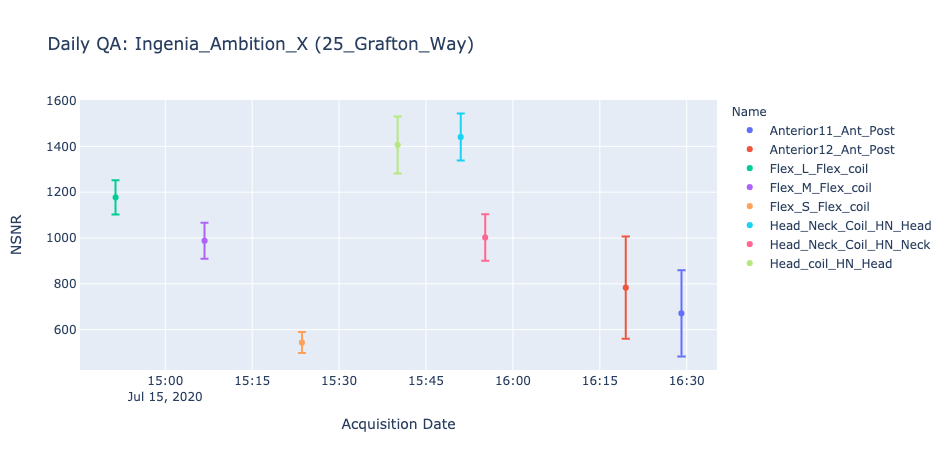

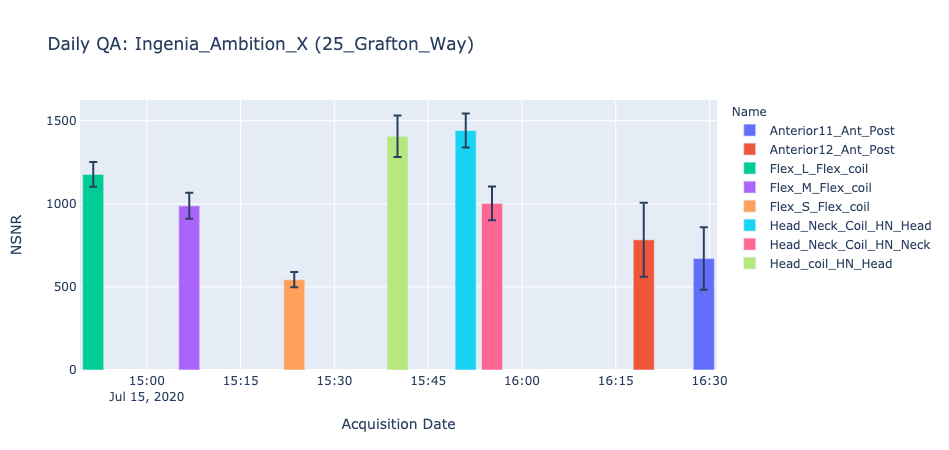

In [32]:
# all_df.to_csv('results_CSV
all_df.head()
fig1=px.scatter(all_df, x='Acquisition Date', y='NSNR',error_y='NSNR_std',title=f'Daily QA: {all_df.ManufacturersModelName[0]} ({all_df.InstitutionAddress[0]})',color='Name')
fig2=px.bar(all_df, x='Acquisition Date', y='NSNR',error_y='NSNR_std',title=f'Daily QA: {all_df.ManufacturersModelName[0]} ({all_df.InstitutionAddress[0]})',color='Name')
fig1.show()
fig2.show()


In [68]:
now=datetime.now()
print(now.strftime("_%d%b%Y"))

_02Aug2020


In [210]:
from numpy.lib.stride_tricks import as_strided as ast


def block_view(A, block= (5,5)):
    """Provide a 2D block view to 2D array. No error checking made.
    Therefore meaningful (as implemented) only for blocks strictly
    compatible with the shape of A."""
    # simple shape and strides computations may seem at first strange
    # unless one is able to recognize the 'tuple additions' involved ;-)
    shape= (int(A.shape[0]/ block[0]), int(A.shape[1]/ block[1]))+ block
    print(shape)
    strides= (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return ast(A, shape= shape, strides= strides)

A=np.arange(128*128).reshape(128,128)
B=block_view(A)
print(A)
print(' ')
print(B[0,0])
A.strides

(25, 25, 5, 5)
[[    0     1     2 ...   125   126   127]
 [  128   129   130 ...   253   254   255]
 [  256   257   258 ...   381   382   383]
 ...
 [16000 16001 16002 ... 16125 16126 16127]
 [16128 16129 16130 ... 16253 16254 16255]
 [16256 16257 16258 ... 16381 16382 16383]]
 
[[  0   1   2   3   4]
 [128 129 130 131 132]
 [256 257 258 259 260]
 [384 385 386 387 388]
 [512 513 514 515 516]]


(1024, 8)

In [34]:
block=(10,10,2)

A_split0=np.array_split(A,np.round(A.shape[0]/block[0]))
A_split01=[np.array_split(a,np.round(A.shape[1]/block[1]),axis=1) for a in A_split0]
# A_split012=[np.array_split(a,np.round(A.shape[2]/block[2]),axis=2) for a in A_split01]